# Modelo multinput

## Modelamiento 

Como primer paso vamos a importar las bibliotecas necesarias

In [1]:
from sklearn.preprocessing import LabelBinarizer,MinMaxScaler,LabelEncoder,OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import concatenate
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import argparse
import locale
import glob
import cv2
import os

Nuestro propósito es **corroborar (o descartar) que agregar las fotos de los choques de autos asegurados permite una estimación más exacta de los montos, respecto del caso base que sólo usa información tabular**.
Para ello haremos uso de una red neuronal _multi input_.

Ya se hizo un trabajo detallado de exploración de los datos, el que se puede encontrar [acá](https://github.com/fedeos/Tesis-UAI/blob/master/EDA%20Tesis%20MIA.ipynb).

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4511041.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
1,img_4511041_180.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
2,img_4511041_270.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
3,img_4511041_90.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
4,img_4511208.jpg,A,32700.0,817.5,2026-05-30,28486.68,0,0.0


Nuestro propósito es contar con un modelo de regresión que relacione el daño (```Amount```) con el resto de las variables:
- Modelo 1: Usando solo fotografías
- Modelo 2: Usando fotografías y además las variables númericas y categóricas

In [4]:
df.dtypes

Image_path            object
Insurance_company     object
Cost_of_vehicle      float64
Min_coverage         float64
Expiry_date           object
Max_coverage         float64
Condition              int64
Amount               float64
dtype: object

In [5]:
df.describe()

,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Amount
count,1601.000000,1601.000000,1601.000000,1696.000000,1685.000000
mean,37790.318551,944.757964,15421.337189,0.766509,3391.451632
std,8944.723303,223.618083,11468.101665,0.423176,3262.359910
min,11100.000000,277.500000,2853.000000,0.000000,-999.000000
25%,30100.000000,752.500000,7953.000000,1.000000,325.000000
50%,37900.000000,947.500000,10578.000000,1.000000,3363.000000
75%,45400.000000,1135.000000,13403.000000,1.000000,5599.000000
max,53500.000000,1337.500000,46495.680000,1.000000,59844.000000


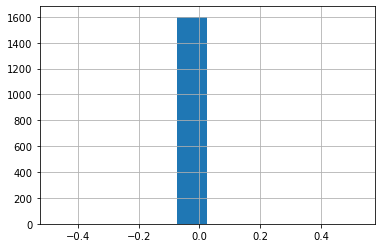

In [6]:
(df['Min_coverage']/df['Cost_of_vehicle']).hist();

In [7]:
df['Insurance_company'].value_counts()

B     172
BQ    167
A     165
AA    159
C     155
BB    154
O     153
DA    152
BC    151
AC    137
RE    131
Name: Insurance_company, dtype: int64

Se debe hacer notar que:
- La cobertura mínima es sistemáticamente el 25% del valor del automóvil, de modo que la variable no aporta información
- Creemos Sería razonable suponer que tanto la máxima cobertura (```Max_coverage```)  como el monto del daño (```Amount```) sean expresados como proporción del costo del vehículo
- Expresaremos ```Expiry_date```como días pendientes de cobertura a partir de una fecha nominal
- Notar que las compañías de seguros son 11 distintas

In [8]:
HOY = pd.to_datetime(datetime.date(2021,6,30)) # Fecha nominal para calcular los días de cobertura pendiente

In [9]:
df.head()

,Image_path,Insurance_company,Cost_of_vehicle,Min_coverage,Expiry_date,Max_coverage,Condition,Amount
0,img_4511041.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
1,img_4511041_180.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
2,img_4511041_270.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
3,img_4511041_90.jpg,C,50800.0,1270.0,2027-03-09,44233.68,0,0.0
4,img_4511208.jpg,A,32700.0,817.5,2026-05-30,28486.68,0,0.0


Generaremos una función ad hoc para contar con conjuntos de entrenamiento y evaluación.  El conjunto de prueba con que contamops no está etiquetado.
Los comentarios pertinentes se agregan en el código de la función.

In [10]:
def preprocesa_atributos(input_path):
    
    '''
    Dada la ruta a un archivo devuelve partición en conjuntos de entrenamiento y validación
    
    input: ruta a un archivo, el que debe contener en una el link a la foto.
    output: Conjuntos de entrenamiento y Validación, además de pd.Series con ruta a las imágenes
    
    
    '''
    
    df=pd.read_csv(input_path)
    df.dropna(inplace=True)
    df = df.drop(columns=['Condition']) # Queremos predecir el monto, por el momento no nos interesa
    df = df[(df['Amount']<=df['Cost_of_vehicle'])] #Filtramos casos: Monto del daño no debiera ser > valor auto
    
    df['Expiry_date']=pd.to_datetime(df['Expiry_date'])
    df['dias_pendientes_cobertura']=(df['Expiry_date']-HOY).dt.days.astype(int) #Permite contar días hasta fin cobertura
    df['relative_amount'] = df['Amount']/df['Cost_of_vehicle'] #Se expresa en términos relativos
    df['relative_max_cov'] = df['Max_coverage']/df['Cost_of_vehicle'] #Se expresa en términos relativos
    
    
    df = df.drop(columns=['Min_coverage','Expiry_date','Max_coverage','Amount'])
    
    scaler = MinMaxScaler() #Vamos a escalar variables numéricas
     
    
    X = df.drop(columns=['relative_amount'])
    y = df['relative_amount']
    
    X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.25, random_state=777)
    
    
    X_train_num = X_train[['Cost_of_vehicle','dias_pendientes_cobertura']]
    X_val_num = X_val[['Cost_of_vehicle','dias_pendientes_cobertura']]
    
    X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), 
                                      columns=X_train_num.columns,
                                      index=X_train.index)
    
    X_val_num_scaled = pd.DataFrame(scaler.transform(X_val_num), 
                                      columns=X_val_num.columns,
                                       index=X_val.index)
    
    lb = LabelBinarizer()# Codificaremos valores categóricos
    
    
    X_train_encoded = pd.DataFrame(lb.fit_transform(X_train['Insurance_company']),
                                    columns=lb.classes_,
                                   index=X_train.index)
    
    X_val_encoded = pd.DataFrame(lb.transform(X_val['Insurance_company']),
                                    columns=lb.classes_,
                                   index=X_val.index)
    
    
    X_train_feat = pd.concat([X_train['relative_max_cov'],X_train_num_scaled,X_train_encoded],axis=1)
    X_val_feat = pd.concat([X_val['relative_max_cov'],X_val_num_scaled,X_val_encoded],axis=1)
    
    X_train_im = X_train['Image_path']
    X_val_im = X_val['Image_path']
    
    
    return X_train_feat,X_train_im, X_val_feat,X_val_im,y_train,y_val
    

In [11]:
X_train_feat,X_train_im, X_val_feat,X_val_im,y_train,y_val = preprocesa_atributos('train.csv')

Dejo esta parte por si quisiera inspeccionar imágenes

In [12]:
'''
i=1 

for indice in X_train_im.index:

    img = cv2.imread('trainImages/'+X_train_im[indice])
    trans_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(trans_img)
    plt.title('foto '+str(i)+':'+str(y_train[indice]))
    plt.show()
    i+=1
'''

"\ni=1 \n\nfor indice in X_train_im.index:\n\n    img = cv2.imread('trainImages/'+X_train_im[indice])\n    trans_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\n    plt.imshow(trans_img)\n    plt.title('foto '+str(i)+':'+str(y_train[indice]))\n    plt.show()\n    i+=1\n"

Debemos cargar las imágenes, como arreglos de numpy.

In [13]:
def carga_imagenes(serie_fotos, inputPath):
    
    nuevas_imagenes = []
    for foto in serie_fotos:
        imagen = cv2.imread(inputPath+'/'+foto)
        imagen = cv2.resize(imagen, (128, 128)) #Dejo todas las fotos en 128 x 128
        nuevas_imagenes.append(imagen)
    return np.array(nuevas_imagenes)/255.0 # Normalizo a factor de 1

Vamos a crear cada modelo por separado

Creamos un generador para modelos que solo usen datos tabulares

In [14]:
def create_mlp(dim, regress=False):
    # Perceptron multicapas muy simple para Redes neuronales
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(1, activation="relu"))

    # ¿Hay nodo de regresión?
    if regress:
        model.add(Dense(1, activation="linear"))

    # Devuelve un modelo
    return model

Creamos un generador para modelos que solo use imágenes

In [15]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=True):
# Ojo: hay que cambiar orden de las dimensiones

    inputShape = (height, width, depth)
    chanDim = -1

    # Definir input del modelos
    inputs = Input(shape=inputShape)

    # Loop para cada uno de los filtros
    for (i, f) in enumerate(filters):
    # Ojo con capas de convolución
        if i == 0:
            x = inputs

    # CONV => RELU => BN => POOL
    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Aplanar nuevamente, luego FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # Aplicar al final
    x = Dense(1)(x)
    x = Activation("relu")(x)

    # ¿Hay nodo de regresión?
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [16]:
imagenes_train = carga_imagenes(X_train_im,'trainResizedImages')
imagenes_val = carga_imagenes(X_val_im,'trainResizedImages')

In [17]:
mlp = create_mlp(X_train_feat.shape[1])

In [18]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [19]:
cnn = create_cnn(128, 128, 3)

In [20]:
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                419432

## Entrenamiento de modelos

Primero voy a entrenar el modelo que solamente contiene imágenes

In [21]:
modelo_imagenes = cnn

opt = Adam(lr=1e-4,decay = 1e-4/200) # Hiperparametros
callback = EarlyStopping(monitor='loss', patience=5) # No quiero gastar recursos innecesarios, con callback

cnn.compile(loss="mean_absolute_error", 
              optimizer=opt)

print("[INFO] Entrenando modelo con imágenes...")
history_imagenes = cnn.fit(
    x=imagenes_train, 
    y=y_train.values,
    validation_data=(imagenes_val, y_val.values),
    epochs=500, 
    batch_size=8,
    callbacks = [callback])

[INFO] Entrenando modelo con imágenes...
[2021-10-08 16:09:59.510 ip-172-16-16-196:17044 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-10-08 16:09:59.535 ip-172-16-16-196:17044 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Train on 1193 samples, validate on 398 samples
Epoch 1/500
1193/1193 [==============================] - 8s 7ms/sample - loss: 0.4329 - val_loss: 0.0831
Epoch 2/500
1193/1193 [==============================] - 8s 7ms/sample - loss: 0.3425 - val_loss: 0.0855
Epoch 3/500
1193/1193 [==============================] - 7s 6ms/sample - loss: 0.3213 - val_loss: 0.0792
Epoch 4/500
1193/1193 [==============================] - 8s 6ms/sample - loss: 0.2799 - val_loss: 0.1120
Epoch 5/500
1193/1193 [==============================] - 8s 6ms/sample - loss: 0.2671 - val_loss: 0.0945
Epoch 6/500
1193/1193 [==============================] - 8s 6ms/sample - loss: 0.2527 - val_loss: 0.0816
Epoch 7

dict_keys(['loss', 'val_loss'])


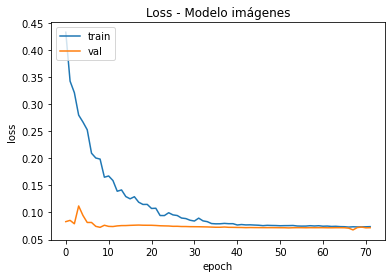

In [22]:
# Listar la historia
print(history_imagenes.history.keys())
# Generar gráficos
plt.plot(history_imagenes.history['loss'])
plt.plot(history_imagenes.history['val_loss'])
plt.title('Loss - Modelo imágenes')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
y_pred_img = cnn.predict(imagenes_val)

In [24]:
error_promedio_imagenes = np.mean(abs(y_pred_img-y_val.values.reshape(-1,1)))

Y ahora entreno el modelo que utiliza como insumos datos tabulares y las fotos

In [25]:
combinedInput = concatenate([mlp.output, cnn.output])
x = Dense(1, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

In [26]:
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

opt = Adam(lr=1e-3,decay = 1e-2/200) # Hiperparametros
callback = EarlyStopping(monitor='loss', patience=5) # No quiero gastar recursos innecesarios, con callback

model.compile(loss="mean_absolute_error", 
              optimizer=opt)

# Entrenamos el modelo
print("[INFO] Entrenando modelo multi input...")
history = model.fit(
    x=[X_train_feat.values, imagenes_train], 
    y=y_train.values,
    validation_data=([X_val_feat.values, imagenes_val], y_val.values),
    epochs=100, 
    batch_size=8,
    callbacks = [callback])


[INFO] Entrenando modelo multi input...
Train on 1193 samples, validate on 398 samples
Epoch 1/100
1193/1193 [==============================] - 9s 7ms/sample - loss: 0.1036 - val_loss: 0.0680
Epoch 2/100
1193/1193 [==============================] - 8s 6ms/sample - loss: 0.0673 - val_loss: 0.0625
Epoch 3/100
1193/1193 [==============================] - 8s 6ms/sample - loss: 0.0622 - val_loss: 0.0577
Epoch 4/100
1193/1193 [==============================] - 7s 6ms/sample - loss: 0.0570 - val_loss: 0.0544
Epoch 5/100
1193/1193 [==============================] - 7s 6ms/sample - loss: 0.0541 - val_loss: 0.0529
Epoch 6/100
1193/1193 [==============================] - 8s 6ms/sample - loss: 0.0534 - val_loss: 0.0519
Epoch 7/100
1193/1193 [==============================] - 8s 6ms/sample - loss: 0.0526 - val_loss: 0.0505
Epoch 8/100
1193/1193 [==============================] - 7s 6ms/sample - loss: 0.0516 - val_loss: 0.0501
Epoch 9/100
1193/1193 [==============================] - 7s 6ms/sample - 

dict_keys(['loss', 'val_loss'])


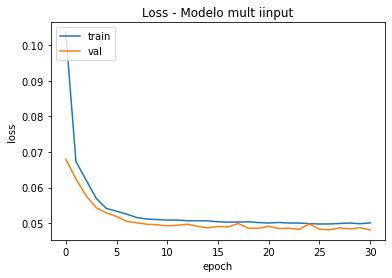

In [27]:
# Listar la historia
print(history.history.keys())
# Generar gráficos
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss - Modelo mult iinput')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
y_pred_mi = model.predict([X_val_feat.values, imagenes_val])

In [29]:
error_promedio_mi = np.mean(abs(y_pred_mi-y_val.values.reshape(-1,1)))

In [30]:
print(f"El error promedio del modelo que solo usa imagenes es {round(error_promedio_imagenes,4)}.\n\
A su vez, el error promedio del modelo multi input es {round(error_promedio_mi,4)}." )

El error promedio del modelo que solo usa imagenes es 0.0719.
A su vez, el error promedio del modelo multi input es 0.0481.
